# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Segmentation</a></div><div class="lev1 toc-item"><a href="#Save-the-Data" data-toc-modified-id="Save-the-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Save the Data</a></div>

# Load Data

In [1]:
import json
import os

In [2]:
def load_data(path):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item['abstract'])
    return data

In [3]:
rawData = load_data('raw_data.json')

In [4]:
len(rawData)

21273

# Word Segmentation

In [5]:
import jieba
import re
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
not_cuts = re.compile(u'([\da-zA-Z\.]+)|《(.*?)》|“(.{1,10})”')
re_replace = re.compile(u'[^\u4e00-\u9fa50-9a-zA-Z\%《》\(\)（）“”·\.]')

In [13]:
filename = "stopwords.txt"
stopWords = {w: None for w in open(filename).read().split()}

In [80]:
def newcut(s):
    """
    Word Segmentation
    """
    result = []
    j = 0
    s = re_replace.sub(' ', s)
    
    for i in not_cuts.finditer(s):
        result.extend(jieba.lcut(s[j:i.start()], HMM=False))
        if s[i.start()] in [u'《', u'“']:
            result.extend([s[i.start()], s[i.start()+1:i.end()-1], s[i.end()-1]])
        else:
            result.append(s[i.start():i.end()])
        j = i.end()
    result.extend(jieba.lcut(s[j:], HMM=False))
    return result

def clean(s):
    """
    Clean data
    """
    for i in range(len(s)):
        if s[i] == ' ':
            s[i] = None
        if s[i] == '(':
            for j in range(i+1, len(s)):
                if s[j] == ')':
                    for k in range(i, j+1):
                        s[k] = None
        if s[i] == '（':
            for j in range(i+1, len(s)):
                if s[j] == '）':
                    for k in range(i, j+1):
                        s[k] = None
        if s[i] == '《':
            for j in range(i+1, len(s)):
                if s[j] == '》':
                    for k in range(i, j+1):
                        s[k] = None
        if s[i] == '%':
            if s[i-1] != None:
                s[i-1] = s[i-1]+'%'
            s[i] = None   
        if s[i] == '“' or s[i] == '”' or s[i] == '"':
            s[i] = None
        if s[i] == '於':
            s[i] = '于'
    return [i for i in s if i != None]

def del_stop(ws):
    """
    Delete stopwords
    """
    return [i for i in [stopWords.get(i, i) for i in ws] if i != None]

In [35]:
sentWords = [del_stop(clean(newcut(s))) for s in rawData]

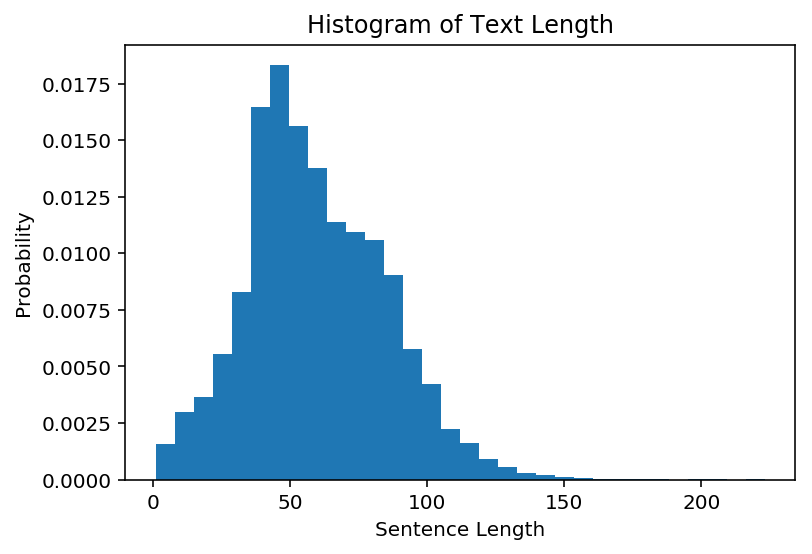

In [36]:
plt.hist([len(i) for i in sentWords], bins=32, normed=True);
plt.xlabel('Sentence Length')
plt.ylabel('Probability')
plt.title('Histogram of Text Length')  

# Save the Data

In [84]:
del_stop(clean(newcut('鉴于该事项尚存在不确定性')))

['事项', '尚存', '不确定性']

In [39]:
len([' '.join(i) for i in sentWords if len(i)<16])

759

In [40]:
len([' '.join(i) for i in sentWords if len(i)>128])

149

In [42]:
max([len(i) for i in sentWords])

223

In [22]:
len(sentWords)

21273

In [43]:
sentence = [rawData[j] for j, i in enumerate(sentWords) if len(i)>=16 and len(i)<=128]

In [50]:
def write_to_file(content):
    with open('train_data.json', 'a', encoding='utf-8') as f:
        f.write(json.dumps(content, ensure_ascii=False) + '\n')
        f.close()
        
def gen_data(data):
    for item in data:
        yield {
            'sentence': item,
            'label': 0
        }

In [51]:
for i in gen_data(sentence):
    write_to_file(i)

In [52]:
!wc -l train_data.json

   20365 train_data.json
